In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00510/Grisoni_et_al_2016_EnvInt88.csv

In [ ]:
!pip install functorch
from functorch import jacrev
from functorch import vmap
import os
import re
import torch
import pandas as pd
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn import datasets
import os
import pickle
import torch
import shutil
import itertools
import argparse
import importlib
import json
import copy
import timeit
from pathlib import Path
import numpy as np
import random
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold
from torch.autograd.functional import jacobian

green = plt.cm.Greens(0.2*(6/4) + 0.4)
blue = plt.cm.Blues(0.2*(6/4) + 0.4)
red = plt.cm.Reds(0.2*(6/4) + 0.4)

DEVICE = 'cuda'
EPOCHS = 200
BATCH_SIZE = 32
TRAINING_PATIENCE = 30

In [4]:
# science plots requirements
!apt-get update
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
import scienceplots
plt.style.use('science')

In [5]:
# data loader
def load_bioconcentration(seed, train_prop=0.8, batch_size=64):
    data = pd.read_csv('Grisoni_et_al_2016_EnvInt88.csv', sep=',')

    X = data[['nHM', 'piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V', 'N-072', 'B02[C-N]', 'F04[C-O]']]
    for var in ['nHM', 'N-072', 'B02[C-N]', 'F04[C-O]']:
        one_hot = pd.get_dummies(X[var], prefix=var) # onehotencode categorical column
        X = X.drop(var, axis=1)
        X = X.join(one_hot)

    y = data['logBCF']
    X, y = X.to_numpy(), y.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_prop, random_state=seed)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1)
    y_test = y_scaler.transform(y_test.reshape(-1,1)).reshape(-1)

    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    loaders = {
        'train': DataLoader(train_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=1),

        'test': DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=1)
    }
    return loaders

In [6]:
# helper functions
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class UCI_MLP(nn.Module):
    def __init__(self, num_features, latent_size, num_outputs, dropout=0, batch_norm=False):
        super(UCI_MLP, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.batch_norm = batch_norm
        d = num_features + 1
        self.fc1 = nn.Linear(num_features, d)
        self.bn1 = nn.BatchNorm1d(d)
        self.relu1 = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(d, d)
        self.bn2 = nn.BatchNorm1d(d)
        self.relu2 = nn.ReLU(inplace=False)
        self.fc3 = nn.Linear(d, num_outputs)

    def forward(self, x):
        out = self.fc1(x)
        if self.batch_norm:
          out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        if self.batch_norm:
          out = self.bn2(out)
        h_output = self.relu2(out)
        h_output = self.dropout(h_output)
        out = self.fc3(h_output)
        return out, h_output

class parameter_schedule:
    def __init__(self, lambda_1, lambda_2, epoch):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.switch_epoch = epoch
        
    def get_reg(self, epoch):
        if epoch < self.switch_epoch:
            return 0, 0
        else:
            return self.lambda_1, self.lambda_2



def train_epoch(model, train_loader, optimiser, l1, l2, ss, regulariser, device='cuda'):
    loss_func = nn.MSELoss()
    # loss_func = nn.CrossEntropyLoss()
    reg_loss = 0
    running_loss = 0
    for i, (data, label) in enumerate(train_loader):
        model.train()
        data, label = data.to(device), label.to(device)
        optimiser.zero_grad()
        output, _ = model(data)

        pred_loss = loss_func(output.squeeze(), label)

        if regulariser == 'TANGOS' and (l1 > 0 or l2 > 0):
            sparsity_loss, correlation_loss = attr_loss(model, data, device=device, subsample=ss)
            reg_loss = l1 * sparsity_loss + l2 * correlation_loss

        loss = pred_loss + reg_loss
        running_loss += pred_loss.item()
        loss.backward()
        optimiser.step()
    return model, running_loss/(i+1)

def evaluate(model, test_loader, device=DEVICE):
    loss_func = nn.MSELoss()
    # loss_func = nn.CrossEntropyLoss()
    running_loss, running_pred_loss = 0, 0
    for epoch, (data, label) in enumerate(test_loader):
        model.eval()
        data, label = data.to(device), label.to(device)

        output, _ = model(data)

        # compute metric
        pred_loss = loss_func(output.squeeze(), label)
        loss = pred_loss

        running_loss += loss.item()
        running_pred_loss += pred_loss.item()

    return running_pred_loss/(epoch + 1), running_loss/(epoch + 1)

def attr_loss(forward_func, data_input, device='cpu', subsample=-1):

    ########## UPDATE functools ############
    batch_size = data_input.shape[0]
    def to_latent(input_):
        _, h_out = forward_func(input_)
        return h_out
    data_input = data_input.clone().requires_grad_(True)
    jacobian = vmap(jacrev(to_latent))(data_input)
    neuron_attr = jacobian.swapaxes(0,1)
    h_dim = neuron_attr.shape[0]
    
    if len(neuron_attr.shape) > 3:
        # h_dim x batch_size x features
        neuron_attr = neuron_attr.flatten(start_dim=2)

    sparsity_loss = torch.norm(neuron_attr, p=1)/(batch_size*h_dim*neuron_attr.shape[2])

    cos = nn.CosineSimilarity(dim=1, eps=1e-6)    
    correlation_loss = torch.tensor(0., requires_grad=True).to(device)
    
    if subsample > 0 and subsample < h_dim*(h_dim-1)/2:
        tensor_pairs = [list(np.random.choice(h_dim, size=(2), replace=False)) for i in range(subsample)]
        for tensor_pair in tensor_pairs:
            pairwise_corr = cos(neuron_attr[tensor_pair[0], :, :], neuron_attr[tensor_pair[1], :, :]).norm(p=1)
            correlation_loss = correlation_loss + pairwise_corr

        correlation_loss = correlation_loss/(batch_size*subsample)

    else:
        for neuron_i in range(1, h_dim):
            for neuron_j in range(0, neuron_i):
                pairwise_corr = cos(neuron_attr[neuron_i, :, :], neuron_attr[neuron_j, :, :]).norm(p=1)
                correlation_loss = correlation_loss + pairwise_corr
        num_pairs = h_dim*(h_dim-1)/2
        correlation_loss = correlation_loss/(batch_size*num_pairs)

    return sparsity_loss, correlation_loss


In [7]:
# training logic
regulariser = 'TANGOS'
latent_size = -1
ss = 200
weight_decay = 0
def train_model(regulariser, latent_size, ss, weight_decay):
    data = load_bioconcentration(0)
    trainloader = data['train']
    valloader = data['test']

    parameter_sched = 0
    lambda_1, lambda_2 = 100, 0.1
    lr = 0.001
    l1, l2 = 0, 0

    model = UCI_MLP(num_features=45, latent_size=latent_size, num_outputs=1).to(DEVICE)
    optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    if regulariser == 'TANGOS':
        parameter_scheduler = parameter_schedule(lambda_1, lambda_2, parameter_sched)
    else:
        parameter_scheduler = None

    best_val_loss = np.inf; last_update = 0
    train_loss = []
    val_loss_ls = []
    epoch_runtimes = []
    for epoch in range(EPOCHS):
        epoch_start = timeit.default_timer()
        if regulariser == 'TANGOS':
            lambda_1, lambda_2 = parameter_scheduler.get_reg(epoch)
            l1 = lambda_1
            l2 = lambda_2

        model, epoch_loss = train_epoch(model, trainloader, optimiser, l1, l2, ss,
                                        regulariser, device=DEVICE)
        val_loss, _ = evaluate(model, valloader, device=DEVICE)

        train_loss.append(epoch_loss)
        val_loss_ls.append(val_loss)

        if (val_loss < best_val_loss) or (epoch < 5):
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            last_update = epoch

        epoch_end = timeit.default_timer()
        epoch_runtimes.append(epoch_end - epoch_start)
        # early stopping criteria
        if epoch - last_update == TRAINING_PATIENCE:
            break
    mean_epoch_runtime = sum(epoch_runtimes)/len(epoch_runtimes)
    results = [mean_epoch_runtime, last_update+1, val_loss_ls[last_update]]
    return results





In [ ]:
# run TANGOS loop
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
TANGOS_results = []
for i in range(10):
    print(i)
    for ss in [25,50,75,100,125,150]:
        results = train_model('TANGOS', i, ss, 0)
        results.extend([latent_size, ss])
        TANGOS_results.append(results)

0
1
2
3
4
5
6
7
8
9


In [8]:
# run baseline (l2) loop
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
l2_results = []
weight = 0.1
for i in range(10):
    print(i)
    results = train_model('L2', i, ss, weight)
    results.extend([latent_size, ss])
    l2_results.append(results)

0
1
2
3
4
5
6
7
8
9


In [ ]:
col_names = ['mean epoch runtime', 'num epochs', 'mse', 'latent size', 'ss']
TANGOS_results_pd = pd.DataFrame(TANGOS_results, columns=col_names)
l2_results_pd = pd.DataFrame(l2_results, columns=col_names)

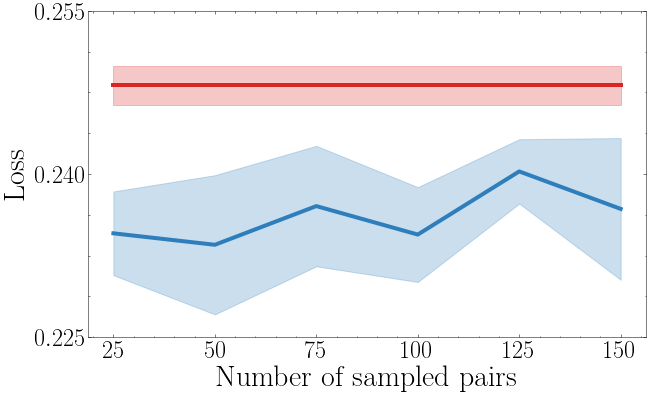

In [ ]:
# plot loss against number of sampled pairs

label_size = 30
ticksize = 24
fs_legend = 30
lwt = 4

plt.figure(figsize=(10,6))
grouped_ss_mean = TANGOS_results_pd.groupby('ss').mean()
grouped_ss_std = TANGOS_results_pd.groupby('ss').std()
plt.plot(grouped_ss_mean.index, grouped_ss_mean['mse'], linewidth=lwt, color=blue)
plt.fill_between(grouped_ss_mean.index, grouped_ss_mean['mse'] - grouped_ss_std['mse'],
                 y2=grouped_ss_mean['mse'] + grouped_ss_std['mse'], color=blue,
                    alpha=0.25)
l2_mean = l2_results_pd['mse'].mean()
l2_std = l2_results_pd['mse'].std()
plt.plot([25, 150], [l2_mean, l2_mean], linewidth=lwt, color=red)
plt.fill_between([25, 150], l2_mean - l2_std, y2=l2_mean + l2_std, color=red,
                    alpha=0.25)

plt.xlabel('Number of sampled pairs', fontsize=label_size)#, labelpad=20)
plt.xticks([25,50,75,100,125,150])
plt.yticks([0.225,0.240,0.255])
plt.ylabel('Loss', fontsize=label_size)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

# plt.title('Performance with increasing number of sampled pairs')
plt.savefig('ss_performance.pdf', format='pdf', dpi=1200)
plt.show()

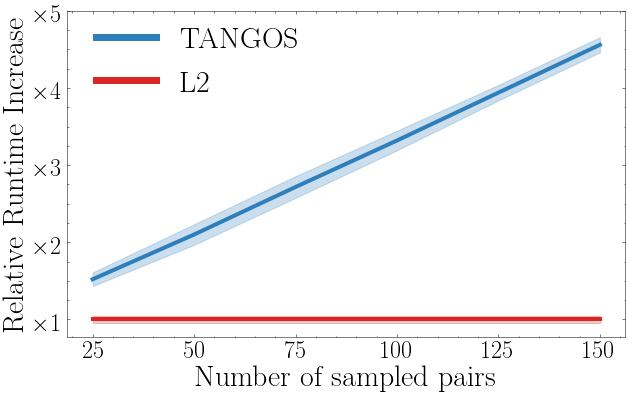

In [ ]:
# plot relative runtime against number of sampled pairs
plt.figure(figsize=(10,6))

plt.plot(grouped_ss_mean.index, grouped_ss_mean['mean epoch runtime'], color=blue, label='TANGOS', linewidth=lwt)
plt.fill_between(grouped_ss_mean.index, grouped_ss_mean['mean epoch runtime'] - grouped_ss_std['mean epoch runtime'],
                 y2=grouped_ss_mean['mean epoch runtime'] + grouped_ss_std['mean epoch runtime'], color=blue,
                    alpha=0.25)

l2_mean = l2_results_pd['mean epoch runtime'].mean()
l2_std = l2_results_pd['mean epoch runtime'].std()
plt.plot([25, 150], [l2_mean, l2_mean], linewidth=lwt, color=red, label='L2')
plt.fill_between([25, 150], l2_mean - l2_std, y2=l2_mean + l2_std, color=red,
                    alpha=0.25)

plt.xlabel('Number of sampled pairs', fontsize=label_size)
plt.xticks([25,50,75,100,125,150])
plt.ylabel('Relative Runtime Increase', fontsize=label_size)
clock_time_ticks = [l2_mean * (i+1) for i in range(5)]
clock_time_labels = [rf'$\times${i+1}' for i in range(5)]
plt.yticks(clock_time_ticks, clock_time_labels)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
lgnd = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fs_legend, frameon=False, loc=(0.03,0.7))
for handle in lgnd.legendHandles:
    handle.set_linewidth(7)
# plt.title('Clock time per epoch with increasing number of sampled pairs')
plt.savefig('ss_speed.pdf', format='pdf', dpi=1200)

plt.show()